In [5]:
# Core Libraries
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch models
import pytorch_lightning as L
import torch.nn as nn
import torch
from torchvision import models, datasets, transforms


# dataset imports
from torch.utils.data import Dataset, DataLoader

# Scikit Learn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

Classi: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


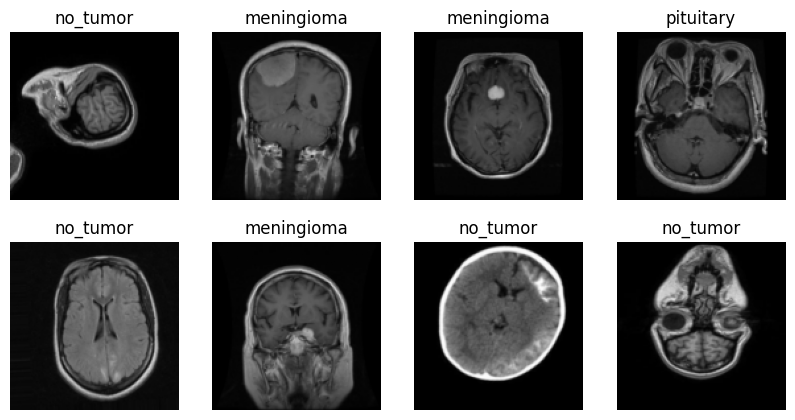

In [10]:
# Visualizaion of dataset properties.

# Dataset . 
train_dir = "data/train"
test_dir = "data/test"


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transforms.ToTensor())

# DataLoader .
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


print("Classi:", train_dataset.classes)

# Examples .
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0)  # da CxHxW a HxWxC
    ax.imshow(img)
    ax.set_title(train_dataset.classes[labels[i]])
    ax.axis("off")
plt.show()



In [ ]:
# Importing the dataset.
class BRISCDataset(Dataset):
    """This class is a version of Dataset which implements the computation in
    the GPU.
    """

    def __init__(self, file_path: str):
        """This constructor intialize the file_path and mode attributes. Also here we
        load the dataset to the cuda device.
        Arguments:
            file_path   The path of the file h5py.
            mode        The modality for accessing the datset correcty.
        """

        # Preload dataset in GPU.
        device = "cuda"

        

    def __len__(self):
        """This function return the len of the dataset."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """This function returns the item at the given index.
        Arguments:
            idx   The data index.
        """
        return self.dataset[idx]


class BRISCDataModule(L.LightningDataModule):
      """This class is a version of the LightningDataModule, after initialization
    it allows to set the dataset and then train dataloader.
    Attributes:
        data_dir      The directory where we have the data.
        batch_size    The dimension of the file.
        preload_gpu   This is a boolean variable that tells whether we should tun on GPU.
        nw            This is the number of workers that load the dataset in parallel.
        dataset       This variable is the dataset itself (can be of 2 types).

    """

    def __init__(
        self,
        data_dir: str,
        batch_size: int = 32,
        num_workers: int = 0,
        preload_gpu: bool = False,
    ):
        """This constructor initialize the main class attributes."""
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.preload_gpu = preload_gpu
        self.nw = num_workers

    def setup(self, stage: str):
        """This function set the dataset, here we check if we have to train on the gpu
        or not and we decide which dataset to use depending on this.
        """
        if self.preload_gpu:
            self.dataset = BRISCDataset(self.data_dir)
        else:
            self.dataset = BRISCDataset(self.data_dir)

    def train_dataloader(self):
        """This function is used to train the class instance on the chosen dataset."""
        if self.preload_gpu:
            dataloader = DataLoader(
                self.dataset, batch_size=self.batch_size, shuffle=True
            )
        else:
            dataloader = DataLoader(
                self.dataset,
                num_workers=self.nw,
                batch_size=self.batch_size,
                shuffle=True,
                pin_memory=True,
            )
        return dataloader

In [ ]:
# Performing data augmentation.

In [ ]:
# Training and fine tuning.
class ResNetFineTuner(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3, freeze_backbone=True):
        super().__init__()
        self.save_hyperparameters()

        # Load pretrained ResNet50
        backbone = models.resnet50(pretrained=True)
        if freeze_backbone:
            for param in backbone.parameters():
                param.requires_grad = False

        # Replace classifier head
        num_ftrs = backbone.fc.in_features
        backbone.fc = nn.Linear(num_ftrs, num_classes)
        self.model = backbone

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        val_loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
# Validation and Test.

In [ ]:
# Printing statistics (seaborn).